In [1]:
import sys

sys.path.insert(0, "/".join(sys.path[0].split("/")[0:-2]) + ("/src"))
import argparse
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from load_data import load

from sisal.kernel_adapted import kernel_adapated, plot_kernel_adapted
from sisal.plot import Plot
from sisal.solver import Solver
from sisal.utils import normalize_train_test_full_loader_given_index

## Dataset

- **DOI:** [10.35079/HBM393.LXBW.274](https://doi.org/10.35079/HBM393.LXBW.274)  
- **Dataset ID:** VAN0046-LK-3-45-IMS_lipids_pos_multilayer.ome 
- **HuBMAP Portal Link:** [View Dataset](https://portal.hubmapconsortium.org/browse/dataset/f67c4c1ce4d2f2d6e3e1e4a7f6be032f)

In [2]:
data_dir = Path(r"../../data/VAN0046-LK-3-45-IMS_lipids_neg_roi=#1_mz=fix")
centroids, mask, mask_to_name, pixel_index, mzs = load(data_dir)

In [3]:
train_loader, test_loader, full_index_loader = normalize_train_test_full_loader_given_index(
    centroids, pixel_index, mask, batch_size=32
)

In [4]:
PATH = "model_kidney.pth"

In [5]:
args = argparse.Namespace(
    beta=4, 
    z_dim=2, 
    in_size = centroids.shape[1],
    epochs=40, 
    device="cpu", 
    save_model_epochs=False, 
    save_loss=False, 
    train=True
)
in_size = centroids.shape[1]

In [6]:
# For reproducibility

# Set a fixed seed
seed = 9335
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # Reproducibility across GPUs

# Deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Training SISAL model  

In [7]:
net = Solver(
    args.beta,
    args.z_dim,
    args.in_size,
    args.epochs,
    args.device,
    args.save_model_epochs,
    args.save_loss,
    args.train)

In [8]:
net.train(train_loader, test_loader, PATH)

Training model:  28%|██▊       | 11/40 [06:14<16:27, 34.04s/epoch]


PosixPath('model_kidney.pth')

## Plot

In [6]:
p = Plot(PATH, args.device, train_loader, test_loader, full_index_loader)
## Remove unlabeled pixels
mask0 = p.label != 0
p.full_latent = p.full_latent[mask0, :]
p.vars = p.vars[mask0, :]
p.label = p.label[mask0]

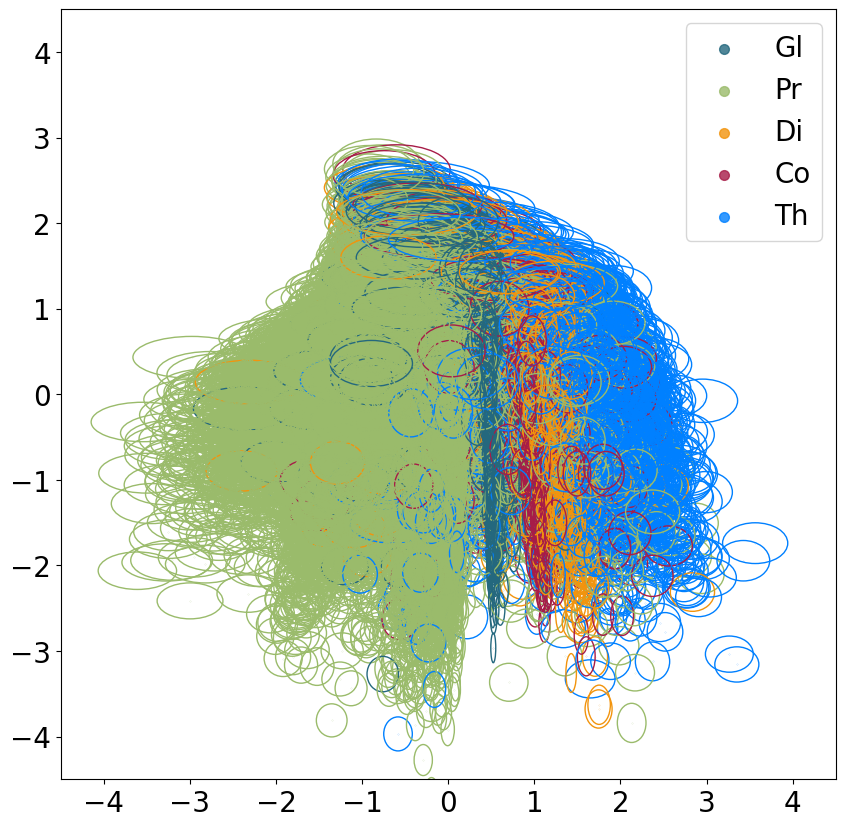

In [7]:
p.plot_latent_dim_with_var(mask_to_name, p=0.6)

## Kernel Density estimation : 

In [8]:
import matplotlib.colors as colors_mat
from load_data import index_to_image_pos, load_image_info

In [9]:
_, image_shape, _ = load_image_info(data_dir)
index_to_image_pos = index_to_image_pos(data_dir)

In [10]:
p = Plot(PATH, args.device, train_loader, test_loader, full_index_loader)

Text(0.5, -0.5, 'New Generated Masks')

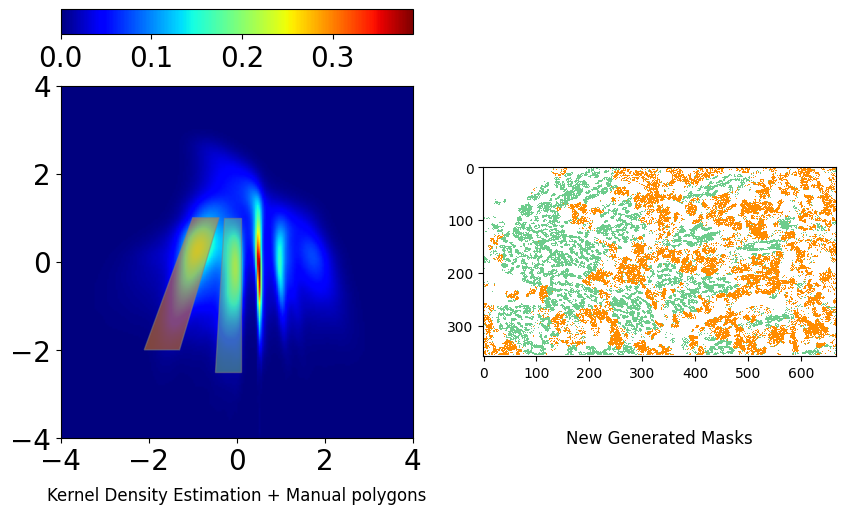

In [11]:
# plot_carving_separate
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
# Left image
axs[0].tick_params(axis="x", labelsize=20)
axs[0].tick_params(axis="y", labelsize=20)
axs[0].set_title("Kernel Density Estimation + Manual polygons", y=-0.2)
image = kernel_adapated(p.full_latent, p.vars)
plot_kernel_adapted(axs[0], fig, image)


pol_limit1 = [(-2.1, -2), (-1.3, -2), (-0.4, 1), (-1, 1)]  # Orange
pol_limit2 = [(-0.5, -2.5), (0.1, -2.5), (0.1, 1), (-0.3, 1)]  #green
pol_limits = [pol_limit1, pol_limit2]
names = ["pr1", "pr2"]
colors = ["darkorange", "#6DCC8C"]  
masks = p.plot_polygons_get_mask(axs[0], pol_limits, colors, index_to_image_pos, image_shape)

# Right image (masks)
cmap_col = colors_mat.ListedColormap(["white", *colors])
axs[1].imshow(masks, cmap_col, interpolation="none")
axs[1].set_title("New Generated Masks", y=-0.5)

## Latent traversal subdivision

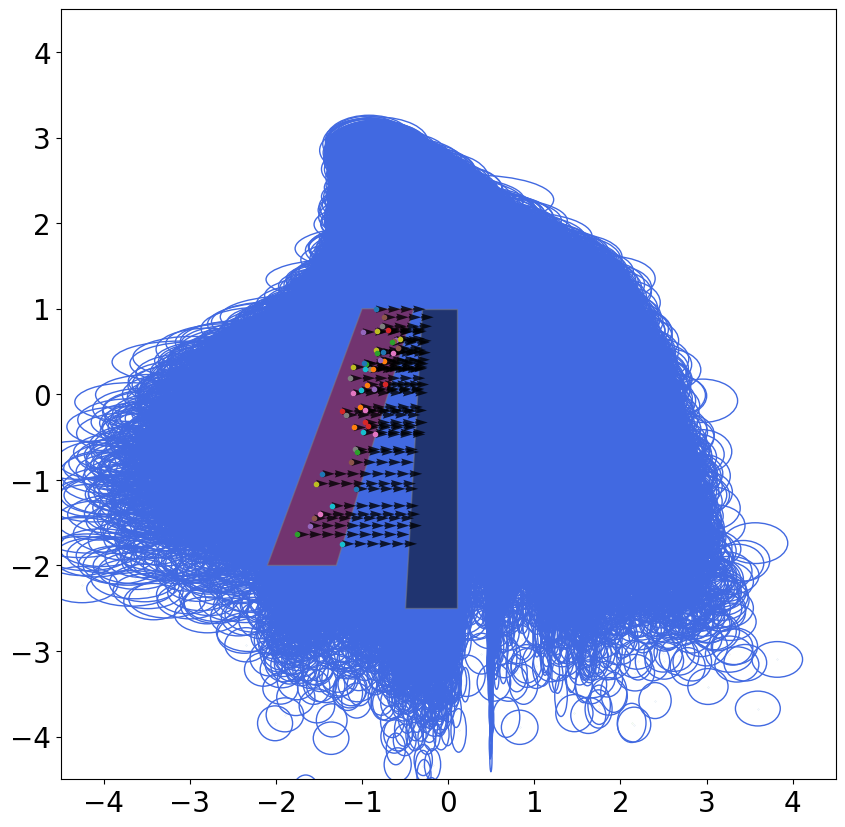

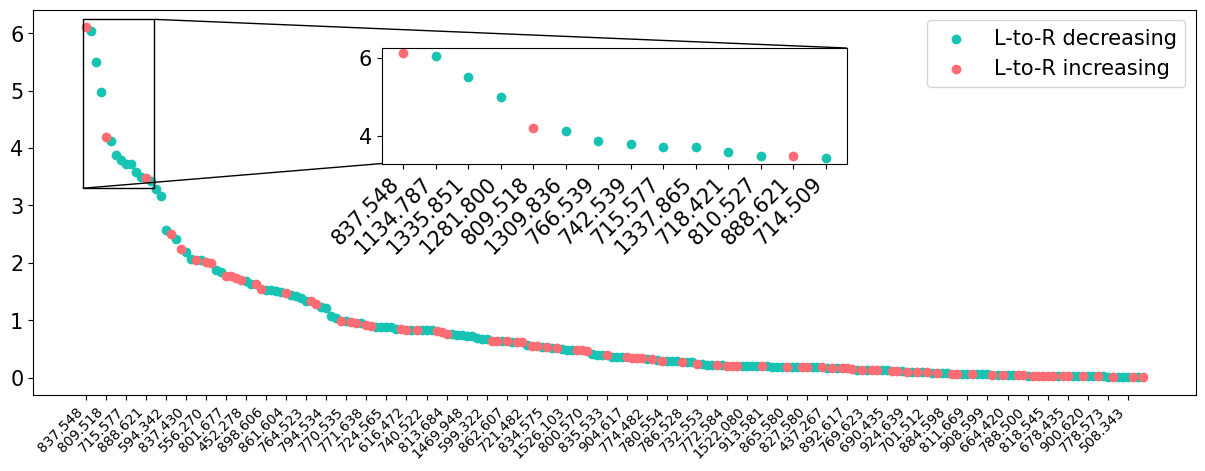

In [12]:
all_points = p.latent_traversal_legs(mask_to_name, pol_limits[0], pol_limits[1])
p.variance_latent_traversal(all_points, mzs, d=centroids.shape[1])